# Convergence of Syntactic Complexity in Conversation

Research based on 'Convergence of Syntactic Complexity in Conversation' by Yang Xu and David Reitter, 2016.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nltk
import sys
from collections import defaultdict
from scipy.stats import binned_statistic

In [2]:
from swda_time import CorpusReader
corpus = CorpusReader('swda_time', 'swda_time/swda-metadata-ext.csv')

In [3]:
ttt = nltk.tokenize.TextTilingTokenizer()

## UtteranceWrapper class

Wrapper for collected utterance data

In [4]:
class UtteranceWrapper:
    def __init__(self, speaker, text, length, depth, width):
        self.speaker = speaker
        self.text = text
        self.length = length
        self.depth = depth
        self.width = width
        self.ntd = None
        self.ntw = None
        
    def set_ntd(self, ntd_const):
        self.ntd = self.depth / float(ntd_const)
        
    def set_ntw(self, ntw_const):
        self.ntw = self.width / float(ntw_const)
        
    def get_all_measures(self):
        return [self.length, self.depth, self.width, self.ntd, self.ntw]

## Collect speaker data

In [5]:
COLLECTOR_VERBOSE = False

def collect_transcript_data():
    """
    Collects a list of lists that cotains the utterance wrappers for all transcripts in the SWDA time dataset
    :return: a list of lists that cotains the utterance wrappers for all transcripts in the SWDA time dataset
    """
    transcripts_list = []
    for transcript in corpus.iter_transcripts(display_progress=True):
        conversation_list = []
        for utterance in transcript.utterances:

    #         sub_utterance = utterance.subutterance_index
    #         print(sub_utterance)

            speaker = utterance.caller
            if COLLECTOR_VERBOSE: print(speaker)
            text = utterance.pos_words()
            if COLLECTOR_VERBOSE: print(text)
            if utterance.trees:         
                # TODO: Currently only considering the first tree # # # # # # # # #
                tree = utterance.trees[0] 
            else:
                # TODO: Handle cases where no tree is found # # # # # # # # # # # # 
                
                # print("WARNING: Utterance {} has no tree!".format(utterance.pos_words()))
                # This only prints full stops
                continue
            
            if COLLECTOR_VERBOSE: tree.pretty_print()
            subtrees = tree.subtrees()

            # Collect syntactic complexity metrics
            # Sentence length
            sentence_length = len(text)
            if COLLECTOR_VERBOSE: print(sentence_length)

            # Tree depth
            tree_depth = tree.height()
            if COLLECTOR_VERBOSE: print(tree_depth)

            node_count = 0
            branching_sum = 0        
            # Branching factor        
            for t in subtrees: 
                if COLLECTOR_VERBOSE: print(t)
                num_children = len(t.leaves())
                if COLLECTOR_VERBOSE: print(num_children)
                node_count += 1
                branching_sum += num_children

            tree_width = branching_sum / float(node_count)
            if COLLECTOR_VERBOSE: print(tree_width)

    #         pos = utterance.pos_lemmas()
    #         print(pos)

            wrapper = UtteranceWrapper(speaker, text, sentence_length, tree_depth, tree_width)
            conversation_list.append(wrapper)
        transcripts_list.append(conversation_list)
        
    return transcripts_list

In [6]:
transcripts_list = collect_transcript_data()

transcript 645


## Calculate normalized measures from collected data

In [7]:
def collect_normalized_data(transcripts_list):
    """
    Calculates normalized tree depth and width by iterating through the collected transcript list 
    and averaging over the recorded numbers
    :param transcripts_list: A list of lists containing utterance wrappers
    :return: Nothing
    """
    length_sum = 0
    depth_sum = 0
    width_sum = 0

    depth_normalizer_dict = defaultdict(lambda: list())
    width_normalizer_dict = defaultdict(lambda: list())
    
    for t, wrapper_list in enumerate(transcripts_list):
        for i, wrapper in enumerate(wrapper_list):
            length = wrapper.length
            depth = wrapper.depth
            width = wrapper.width

            if t % 100 == 0 and i % 100 == 0:
                print("Utterance {}: Length {} - Depth {} - Width {}".format(i, length, depth, width))

            length_sum += length
            depth_sum += depth
            width_sum += width

            depth_normalizer_dict[length].append(depth)
            width_normalizer_dict[length].append(width)
            
    depth_normalizer_const = dict()
    width_normalizer_const = dict()

    for key, depth_list in depth_normalizer_dict.items():
        depth_normalizer_const[key] = np.average(depth_list)
    for key, width_list in width_normalizer_dict.items():
        width_normalizer_const[key] = np.average(width_list)

#     for key in depth_normalizer_dict.keys():
#         print("Normalizing constants for length {}: Depth {} - Width {}".format(key, depth_normalizer_const[key], width_normalizer_const[key]))

    for t, wrapper_list in enumerate(transcripts_list):
        for i, wrapper in enumerate(wrapper_list):
            key = wrapper.length
            wrapper.set_ntd(depth_normalizer_const[key])
            wrapper.set_ntw(width_normalizer_const[key])
            
            if t % 100 == 0 and i % 100 == 0:
                print("Utterance {}: Normalized Depth {} - Normalized Width {}".format(i, wrapper.ntd, wrapper.ntw))

In [8]:
collect_normalized_data(transcripts_list)

Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 3 - Depth 4 - Width 1.42857142857
Utterance 200: Length 2 - Depth 3 - Width 1.5
Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 2 - Depth 3 - Width 1.5
Utterance 0: Length 2 - Depth 4 - Width 1.42857142857
Utterance 100: Length 13 - Depth 12 - Width 2.84375
Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 5 - Depth 5 - Width 1.83333333333
Utterance 200: Length 2 - Depth 3 - Width 1.5
Utterance 0: Length 11 - Depth 9 - Width 2.39285714286
Utterance 100: Length 6 - Depth 6 - Width 1.66666666667
Utterance 0: Length 9 - Depth 5 - Width 1.6875
Utterance 100: Length 31 - Depth 10 - Width 2.90361445783
Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 12 - Depth 16 - Width 4.70588235294
Utterance 0: Normalized Depth 0.923368569553 - Normalized Width 0.973457715677
Utterance 100: Normalized Depth 0.762731938413 - Normalized Width 0.798988919091
Utterance 200: Normalized Depth 0.

## Chunk the data to display measures through the course of a dialogue/topic

In [9]:
def chunk(seq, num_bins):
    """
    Splits or replicates the data to fill a given number of bins
    :param seq: List of elements to be split
    :param num_bins: Number of bins to be filled
    :return: List of lists containing the chunks
    """    
    # If sequence length is higher than the bin count: Chunk
    if len(seq) > num_bins:   
        k, m = divmod(len(seq), num_bins)
        chunks = list((seq[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in xrange(num_bins)))
        assert len(chunks) == num_bins
        return chunks
    # Else: Replicate some of the data to strech it into the bins
    else:
        chunks = [None] * num_bins
        avg = num_bins / float(len(seq))
        last = 0.0
        for item in seq:
            indeces = range(int(last), int(last + avg))
            for i in indeces:
                chunks[i] = item
            last += avg
        if not chunks[-1]: chunks[-1] = seq[-1] 
        assert len(chunks) == num_bins
        return chunks      

In [10]:
def get_chunk_means(seq, num_bins):
    """
    Calculates the means of a given list of items, split into num_bins 
    :param seq: A list of measurements
    :param num_bins: Number of bins to split the data in
    :return: List of num_bins means of sequence seq
    """
    chunks = chunk(seq, num_bins)
#     print(chunks)
    means = [np.mean(c) for c in chunks]
    return means

In [11]:
def collect_speaker_data(wrappers, num_bins):
    """
    Collects mean complexity measures over time for all speakers 
    :param wrappers: A list of wrappers to be processed
    :param num_bins: Number of bins to split the data in (time steps)
    :return: A dictionary indexed by speaker containing dictionaries indexed by measurement
    """
    data = defaultdict(lambda: list())
    [data[wrapper.speaker].append(wrapper.get_all_measures()) for wrapper in wrappers]
    
    chunk_means = defaultdict(lambda: defaultdict(lambda: list()))   
    for speaker, speaker_data in data.items():
        data_array = np.asarray(speaker_data)
#         print("Speaker {}: {} utterance(s)".format(speaker, len(data_array)))
#         print(data_array.T)
        
        for m, column in enumerate(data_array.T):  
            chunk_means[speaker][m] = get_chunk_means(column, num_bins)
    return chunk_means

In [12]:
def get_measure_name(measure):
    """
    Returns the string name of a measurement
    :param measure: integer index of a measurement
    :return: the string name of a measurement
    """
    if measure == 0:
        return "Sentence Length"
    elif measure == 1:
        return "Tree Depth"
    elif measure == 2:
        return "Tree Width"
    elif measure == 3:
        return "Normalized Tree Depth"
    elif measure == 4:
        return "Normalized Tree Width"

def plot_speaker_data(chunk_means, measure):
    """
    Plots a given measure for all speakers given the data collected in chunk_means
    :param chunk_means: Collected data for a dialogue/topic
    :param measure: integer index of the measure to be displayed
    :return: Nothing
    """
    legend_text = []
    means_list = []
    for speaker in chunk_means.keys():        
        legend_text.append("Speaker " + speaker)
        means_list.append(chunk_means[speaker][measure])
                 
#     differences = np.abs(np.subtract(np.asarray(means_list[0]), np.asarray(means_list[1])))
#     legend_text.append("Differences")
#     means_list.append(list(differences))
    for items in means_list: plt.plot(items)    
    plt.ylabel(get_measure_name(measure))
    plt.xlabel('Within-conversation position of sentence')
    plt.title("Comparison of " + get_measure_name(measure))
    plt.legend(legend_text)
    plt.show()
    
def plot_speaker_differences(overall_means, measure):
    """
    Only plots measurement differences between two speakers
    :param overall_means: Collected data for a dialogue/topic
    :param measure: integer index of the measure to be displayed
    :return: Nothing
    """
    means_list = []
    for speaker in overall_means.keys():        
        means_list.append(overall_means[speaker][measure])
    differences = np.abs(np.subtract(np.asarray(means_list[0]), np.asarray(means_list[1])))
    legend_text = ["Differences"]
    plt.plot(list(differences))    
    plt.ylabel(get_measure_name(measure))
    plt.xlabel('Within-conversation position of sentence')
    plt.title("Comparison of " + get_measure_name(measure))
    plt.legend(legend_text)
    plt.show()

## Show the comparison of measurements over time

In [13]:
def collect_overall_means(chunk_means):
    """
    Calculates the averages over data collected in a list of speaker->measurement->measures dictionaries
    :param chunk_means: a list of speaker->measurement->measures dictionaries
    :return: a speaker->measurement->measures dictionary of averages calculated from the input list
    """
    overall_sums = defaultdict(lambda: defaultdict(lambda: list()))
    for means in chunk_means:
        for s, measures in means.items():
            for m, v in measures.items():
                overall_sums[s][m].append(v)

    overall_means = dict()
    for s, measures in overall_sums.items():
        mean_speaker_data = dict()
        for m, data in measures.items():
            mean_speaker_data[m] = np.mean(data, axis = 0)
        overall_means[s] = mean_speaker_data
    
    return overall_means

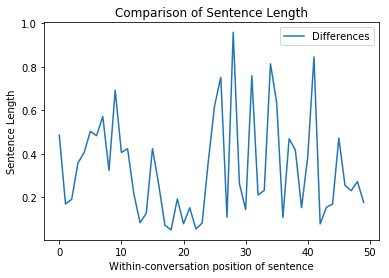

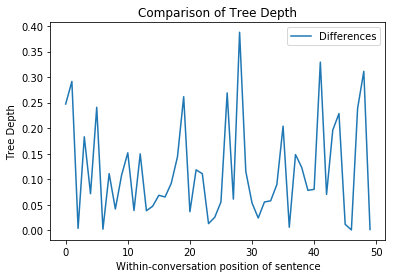

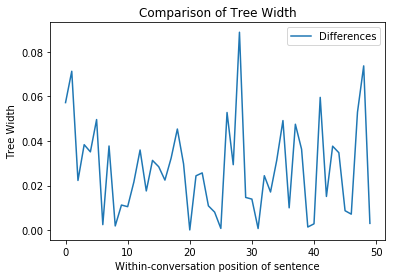

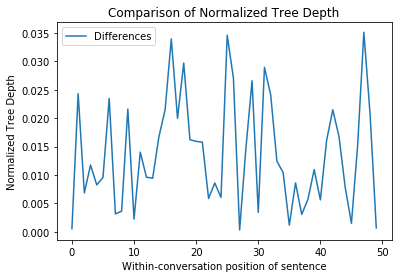

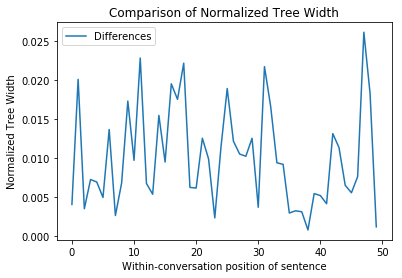

In [14]:
chunk_means = []

for transcript in transcripts_list:
    chunk_means.append(collect_speaker_data(wrappers = transcript, num_bins = 50))
    
overall_means = collect_overall_means(chunk_means)
for measure in range(5):
    plot_speaker_differences(overall_means, measure)

## Topic segmentation with TextTiling

In [15]:
def get_transcript_texts():
    """
    Collects the text-only transcripts of the SWDA time corpus, 
    represented as lists of utterances by the different speakers over time
    :return: A list of text-only transcripts of the SWDA time corpus 
    """
    transcript_texts = []
    for transcript in corpus.iter_transcripts(display_progress=True):
        conversation_text = ""
        last_turn_index = 1
        for utterance in transcript.utterances:
            current_turn_id = utterance.turn_index
            if current_turn_id != last_turn_index:
                conversation_text += "\n\n\n\t"
            conversation_text += " " + " ".join(utterance.pos_words())
            last_turn_index = current_turn_id
        conversation_text += "\n\n\n\t"
        transcript_texts.append(conversation_text)

    return transcript_texts

In [16]:
def get_topic_start_indexes(tiles, transcript_data):
    """
    Given tiles produced by a topic segmentation algorithm, determine the utterance indexes of the splits
    :param tiles: Tiles produced by a topic segmentation algorithm
    :param transcript_data: A list of utterance wrappers collected for the given transcript
    :return: A list of indexes of the topic splits in the original transcript
    """
    topic_start_indexes = []
    tile_index = 0
    tile_length = len(tiles[tile_index].replace('\n\n\n\t', "").strip().split(" "))
    
    block_length = 0
    last_index = 0
    for i, wrapper in enumerate(transcript_data):
        block_length += wrapper.length
        
#         print(tile_length, block_length)    
#         print("- - T: {}".format(tiles[tile_index].replace('\n\n\n\t', "").strip().split(" ")))
#         block_text = []
#         for wrapper in transcript_data[last_index:i]:
#             block_text.extend(wrapper.text)
#         print("- - B: {}".format(block_text))

        if block_length == tile_length:
            topic_start_indexes.append(i)
            block_length = 0
            tile_index += 1

            
            if tile_index < len(tiles):
                tile_length = len(tiles[tile_index].replace('\n\n\n\t', "").strip().split(" "))
                last_index = i
           
    return topic_start_indexes

## Show the comparison of measurements over time

In [17]:
transcript_texts = get_transcript_texts()

transcript 645


In [18]:
def collect_topic_data(transcript_texts, transcripts_list, num_bins = 10):
    """
    Collects the average speaker complexity measures over a collected set of transcripts
    :param transcript_texts: A list of text-only transcripts 
    :param transcripts_list: A list of lists containing the utterance wrappers collected for the given transcripts
    :param num_bins: The number of bins to split the data in (time steps)
    :return: 
    """
    ROLES_VERBOSE = False
    
    overall_means = []
    for i, text in enumerate(transcript_texts):
        
#         if i == 0: ROLES_VERBOSE = True
        sys.stderr.write("\r")
        sys.stderr.write("transcript %s" % i)
        sys.stderr.flush()
        
#         print(text)
        tiles = ttt.tokenize(text)
        if ROLES_VERBOSE: 
            for j, tile in enumerate(tiles):
                print(j)
                print(tile)
                print('\n')
            
        topic_start_indexes = get_topic_start_indexes(tiles, transcripts_list[i])
#         print("Topic start indexes: {}".format(topic_start_indexes))
        if not topic_start_indexes:
#             print("WARNING: No topic start indeces!")
            continue

        wrapper_list = transcripts_list[i]
        tile_counter = 1
        last_index = topic_start_indexes[0]
        last_speaker = wrapper_list[last_index].speaker
        
        chunk_means = []
        for i in topic_start_indexes[1:]:
            if ROLES_VERBOSE: print("Topic segment {}: Utterances {} through {}".format(tile_counter, last_index, i-1))
            wrappers = wrapper_list[last_index:i]    
            
            if ROLES_VERBOSE: print(wrappers[0].text)
            
            speaker_data = collect_speaker_data(wrappers, num_bins)
        
            # Determine the speaker roles in the topic
            topic_initiator = wrapper_list[last_index].speaker
            if ROLES_VERBOSE: print("First speaker is {}".format(topic_initiator))
            
            if topic_initiator == last_speaker:
                topic_leader = topic_initiator
            else:
                for wrapper in wrapper_list[last_index:i]:
                    if wrapper.length >= 5:
                        topic_leader = wrapper.speaker
                        break
            assert topic_leader 
            
            if ROLES_VERBOSE: print("Leader is {}".format(topic_leader))
            try:
                speaker_data['Leader'] = speaker_data.pop(topic_leader)
            except KeyError: 
                print(speaker_data)
            for key in speaker_data.keys():
                if key != 'Leader':
                    speaker_data['Follower'] = speaker_data.pop(key)
           
            chunk_means.append(speaker_data)         
            tile_counter += 1
            last_index = i
            last_speaker = wrapper_list[i-1].speaker
            
            if ROLES_VERBOSE: print("Last speaker is {}".format(last_speaker))
            
        overall_means.append(collect_overall_means(chunk_means))
        
    return overall_means    

In [19]:
overall_means = collect_topic_data(transcript_texts, transcripts_list)       

transcript 641

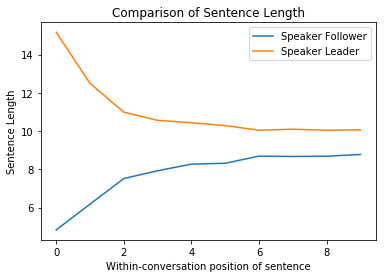

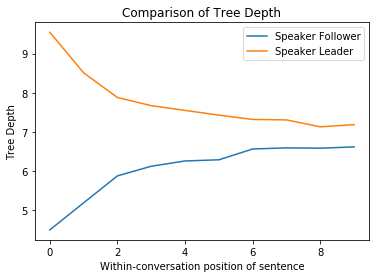

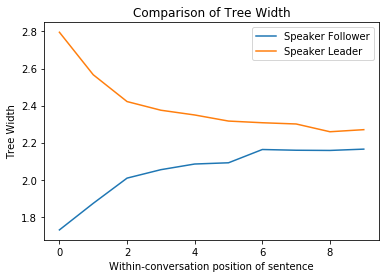

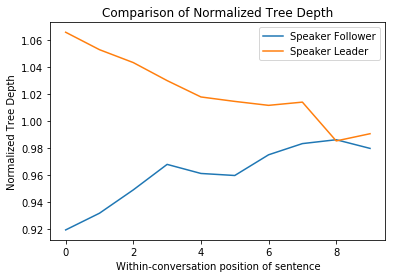

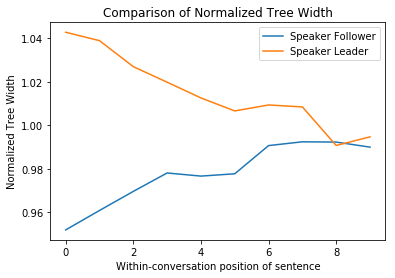

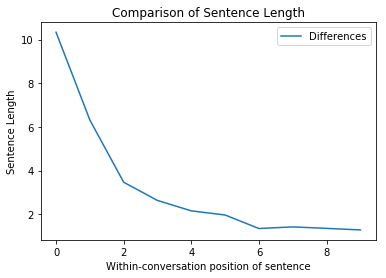

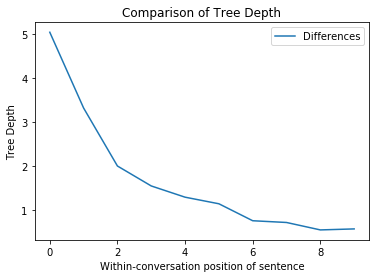

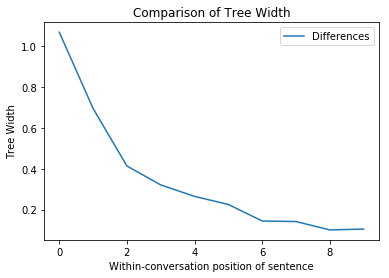

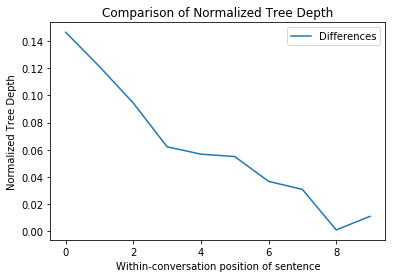

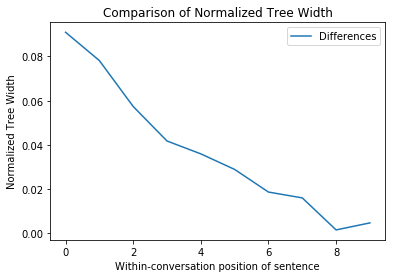

In [20]:
topics_overall_means = collect_overall_means(overall_means)     
for measure in range(5):
    plot_speaker_data(topics_overall_means, measure)     
for measure in range(5):
    plot_speaker_differences(topics_overall_means, measure)     

## Analysis of topic shift points

In [21]:
def calculate_shift_means(overall_means):
    shift_means = []
    
    for i in range(len(overall_means)-2):
        topic_means = overall_means[i:i+2] 
#         print(len(topic_means))
        pair_means = defaultdict(lambda: defaultdict(lambda: list()))

        for topic in topic_means:
            for role, measure_dict in topic.items():
                for m, v in measure_dict.items():
                    pair_means[role][m].extend(v)

#         print(pair_means)
        for role, measure_dict in pair_means.items():
            for m, v in measure_dict.items():
                pair_means[role][m] = np.asarray(v)
            
        for role, measure_dict in pair_means.items():
            pair_means[role] = dict(measure_dict)

        shift_means.append(dict(pair_means))
#         break
        
    return shift_means

In [22]:
print(len(overall_means))

overall_cleaned = []
for mean in overall_means:
     if mean != {}: overall_cleaned.append(mean)
            
print(len(overall_cleaned))

559
477


In [23]:
shift_means = calculate_shift_means(overall_cleaned)

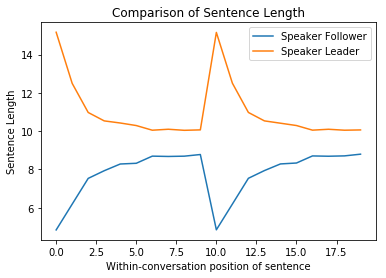

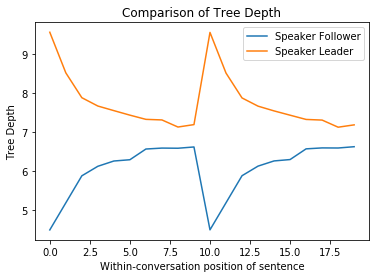

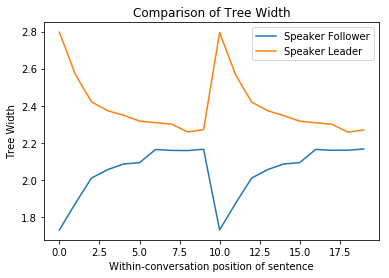

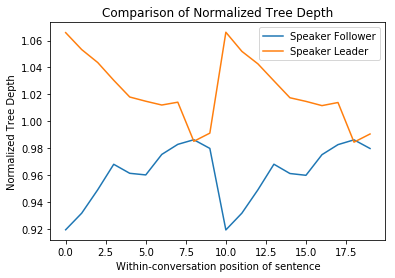

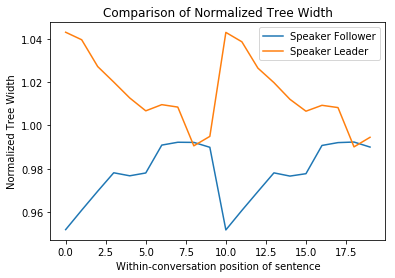

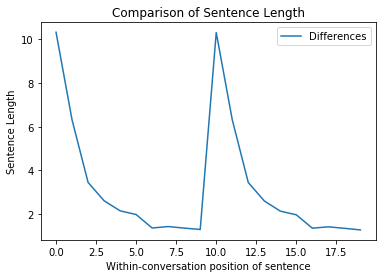

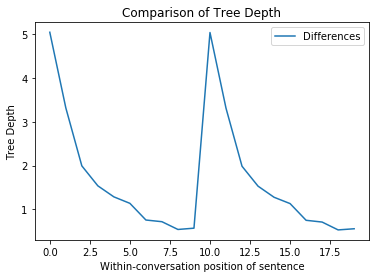

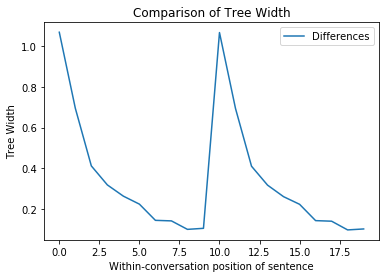

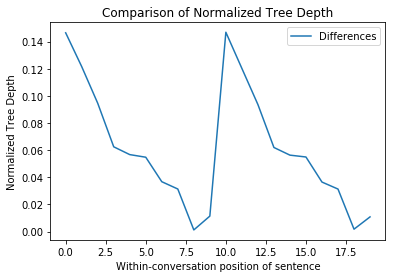

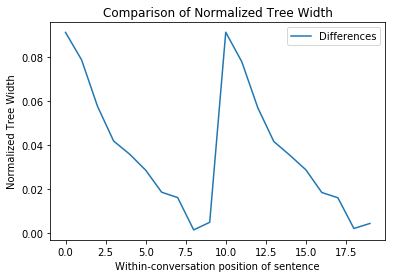

In [24]:
overall_shift_means = collect_overall_means(shift_means)

for measure in range(5):
    plot_speaker_data(overall_shift_means, measure)     
for measure in range(5):
    plot_speaker_differences(overall_shift_means, measure)  